In [45]:
import numpy as np
import matplotlib.pyplot as plt
from arc import *  # Import ARC (Alkali Rydberg Calculator)
from qutip import *
from scipy.fft import fft, ifft
from scipy import constants 

In [46]:
def C(F,m):
  return np.sqrt(F*(F+1)-m*(m+1))

In [261]:
# define parameters used for the simulation
Bx = 0.1e-3       # Magnetic field along x in T
By = 0.1*Bx       # Magnetic field along y in T
omega_y = 3e6   # Magnetic field RF frequency in (Hz)
# constants
muB = 9.2740100783*1e-24 # Bohr magneton SI units
# Load parameters for Caesium from Library ARC
atom = Caesium()
# get the hyperfine structure coupling coefficients in Hz for each line
Coeff_ground    = atom.getHFSCoefficients(6,0,0.5) # 6S1/2
Coeff_D1        = atom.getHFSCoefficients(6,1,0.5) # 6P1/2
Coeff_D2        = atom.getHFSCoefficients(6,1,1.5) # 6P3/2
nu_hfs_ground   = Coeff_ground[0]   # nu_hfs in HZ
nu_hfs_D1       = Coeff_D1[0]       # nu_hfs in HZ
nu_hfs_D2       = Coeff_D2[0]       # nu_hfs in HZ

# T : normalization time used for the simulation
T = (2*np.pi)*(constants.hbar)/(0.25*muB*Bx)

print(T*1e3)
print(1e-3*T**-1)

0.0028579094023217246
349.9061234018176


In [262]:
# Here is the Class alk_atom created by Maimouna Bocoum - 01-08-2023
class alk_atom:
    def __init__(self,myList:list):
        # test the type of the list and trck error
        #try:
            self.MakeAtomFromList(myList)

        # except:
        #     print("error in construction format inpout. exemple of acceptable inpout: [ [0,[3,4]] , [1,[3,4]] ]")
        # pass

    def AddLeveltoList(self,Level:list):
          # Level exemple of list structure: [0,[1,2]], for l=0 ; F=1 and F=2
        self.LevelList.append(Level)
        self.MakeAtomFromList()
        
    def MakeAtomFromList(self,myList):
            N = len(myList)
            self.LevelList = myList
            self.F = []
            self.L = []
            self.J = []
            self.M = []

            for loop in range(0,N):
                Line = myList[loop]  # get l orbital number. l=0 for 6S1/2 , l=1 for 6P1/2 and 6P3/2
                F = Line[2]          # get list of hyperfine F values
                for f in range(0,len(F)):
                     for m in range(0,F[f]*2+1):
                        self.L.append(Line[0])
                        self.J.append(Line[1])
                        self.F.append(F[f])
                        self.M.append( - F[f] + m )
                        
            self.N = len(self.M)

            # count how many levels are not in the ground state
            self.N_notground = 0
            for loop in range(0,self.N):
                if [self.L[loop] , self.J[loop] , self.F[loop]]!=[0,0.5,min(self.F)]:
                    self.N_notground = self.N_notground + 1

    def BuildMvector(self):
        self.M = []
        for i in range(0,len(self.F)):
             for m in range(0,self.F[i]*2+1):
                self.M.append( - self.F[i] + m )

    def printAtom(self):
        print(self.N)
        print(self.LevelList)
        print(self.L)
        print(self.J)
        print(self.F)
        print(self.M)

    #@classmethod
    def FetchKetIndex(self,Level:list):
         # get List of all elements
        KetList = []
        for loop in range(0,self.N,1):
            KetList.append([self.L[loop],self.J[loop],self.F[loop],self.M[loop]])
        return [ i for (i,e) in enumerate(KetList) if e == Level ]



In [263]:
# initialize by list of line est hyperfine levels to account for
# exmple [l=0, F=[3,4]] is the 6S1/2 level, for F=3 and F=4.
# All mF level will be automatically filled by -F<= mF <= F.

# preparation state for the MORS in list of [[l,j,[F]]]
myList = [ [0,0.5,[4]] ]
my_cesium = alk_atom(myList)
my_cesium.printAtom()

IndexList = []
loop = 0

print(my_cesium.FetchKetIndex([0,0.5,3,-3]))
#print([ i for (i,e) in enumerate([1,3,4,5,6]) if 1 == any([1,5])] )



9
[[0, 0.5, [4]]]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[4, 4, 4, 4, 4, 4, 4, 4, 4]
[-4, -3, -2, -1, 0, 1, 2, 3, 4]
[]


In [264]:
# initialize quantum initial state
# by convention, the order of the basis is that of my_cesium.M
# phi0 = basis( my_cesium.N , my_cesium.N-1 )
# phi1 = basis( my_cesium.N , my_cesium.N-2)
#rho0 = phi0*phi0.dag() + 0.7*phi1*phi1.dag()

# rho0 = Qobj(dims=[[my_cesium.N],[my_cesium.N]])
# for i in range(my_cesium.N_notground,my_cesium.N,1): # equidistribution of over all element of the Hilbert base
#     rho0 += basis(my_cesium.N,i)*basis(my_cesium.N,i).dag()


phi0 = basis( my_cesium.N , 0)
for i in range(1,my_cesium.N):
    phi0 = phi0 + basis( my_cesium.N , i)

rho0 = phi0*phi0.dag()

rho0 = rho0/rho0.tr() # normalize by trace norm Trace
# print(rho0)
# print(rho0.tr())

In [265]:
# self construction of spinnor operator
Sigma = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for i in range(0,my_cesium.N,1):
     for j in range(0,my_cesium.N,1):
        Sigma += basis(my_cesium.N, i)*basis(my_cesium.N, j).dag()

# self construction of Jx operator in hbar unit, where x is the quantization axis
Jx = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N,1):
        Jx.data[m,m] = my_cesium.M[m]

# self construction of Jy operator in hbar unit (Jy is adimensioned)
Jy = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N-1,1):
     Jy+=0.5*C(my_cesium.F[m],my_cesium.M[m])*( basis(my_cesium.N, m+1)*basis(my_cesium.N, m).dag() 
                                               + basis(my_cesium.N, m)*basis(my_cesium.N, m+1).dag() )
     # note that C(n,n) = 0 which makes this loop not overlap basis with different F values

# # self construction of Jz operator in hbar unit
Jz = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N-1,1):
    Jz+=-0.5*1j*C(my_cesium.F[m],my_cesium.M[m])*( basis(my_cesium.N, m+1)*basis(my_cesium.N, m).dag() 
                                                  - basis(my_cesium.N, m)*basis(my_cesium.N, m+1).dag() )


# Here, we create the adimension OMEGAs and OMEGAsqz operator in order to define the Hamiltoninan
OMEGAs          = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
OMEGAsqz        = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
for m in range(0,my_cesium.N,1):

        gf = atom.getLandegf( my_cesium.L[m] , my_cesium.J[m] , my_cesium.F[m] ) # get Landé coefficient getLandegf(s,j,F)

        omegas = (gf*muB*Bx)/(constants.hbar)

        OMEGAs.data[m,m] = (omegas*T) # normalized value by (0.25*mu_B*B/hbar)

        nu_hfs = atom.getHFSCoefficients(6,my_cesium.L[m],my_cesium.J[m])[0] # get hyperfine constant in Hz for orbital(n,l,j)

        omega_sqz = (2*omegas**2)/(2*np.pi*nu_hfs)

        OMEGAsqz.data[m,m] = T*omega_sqz
     # note that C(n,n) = 0 which makes this loop not overlap basis with different F values


# # self construction of atome hamiltoninan H0 operator in hbar unit, in absence of By RF field
H0 = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
H0 = OMEGAs*Jx + OMEGAsqz*Jx*Jx

# time varying term for the Hamiltonin
def H1_coeff(t,arg):
    return (By/Bx)*np.cos(T*omega_y*t)

H1 = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
H1 = OMEGAs*Jy # the time varying term (By/Bx) is defined in function By

# construction of time varying Hamiltoninan
H = [H0,[H1, H1_coeff]]

c:\Users\Maimouna\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [266]:
# Collapse operators c_ops = [[C0, py_coeff0], C1, [C2, py_coeff2], ...] 
# We will consider that All level collapse exepct for the ground state (l=0,j=0.5,F=3). Loop should be performed on all other levels.
# not that all level are ordered by increasing energy so that collapse are each to populate in j>loop
Cops = [Qobj(dims=[[my_cesium.N],[my_cesium.N]]) for i in range(my_cesium.N)] # initializing an empty list

offset = my_cesium.N - my_cesium.N_notground # element to skip the the basis to reach first collapsing ket
for loop in range(0,my_cesium.N_notground,1): # loop on excited states
            # we now distinguish all case for the possible deacays
            if [my_cesium.L[offset+loop] , my_cesium.J[offset+loop] , my_cesium.F[offset+loop]] \
                ==[0,0.5,min(my_cesium.F)+1]:
                # spin decay
                for j in range(0,offset +loop,1): # loop on all ket lower in energy than the current one
                    gamma = 500 # we set the decay rate to 10 Hz / (gamma*constants.hbar)/(muB*Bx)
                    Cops[loop] = Cops[loop] + \
                        np.sqrt(gamma*T)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()
            elif [my_cesium.L[loop] , my_cesium.J[loop] , my_cesium.F[loop]]==[1,0.5,min(my_cesium.F)+1]:
                # radiative decay 6P1/2
                for j in range(0,offset +loop,1): # loop on all ket lower in energy than the current one
                    gamma = atom.getStateLifetime(6,1,0.5, temperature=300,includeLevelsUpTo=7)
                    Cops[loop] = Cops[loop] + \
                        np.sqrt(gamma*T)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()
            elif [my_cesium.L[loop] , my_cesium.J[loop] , my_cesium.F[loop]]==[1,1.5,min(my_cesium.F)+1]:
                # radiative decay 6P3/2
                for j in range(0,offset +loop,1): # loop on all ket lower in energy than the current one
                    gamma = atom.getStateLifetime(6,1,1.5, temperature=300,includeLevelsUpTo=7)
                    Cops[loop] = Cops[loop] + \
                        np.sqrt(gamma*T)*basis(my_cesium.N, j)*basis(my_cesium.N, offset + loop).dag()


print(1e3*(100*constants.hbar)/(muB*Bx))
print(offset)
print(my_cesium.N)
print(Cops[4])



0.011371260207207667
9
9
Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [267]:
# Simulation of the dynamic in absence of RF Magnetic field
opts = Options()
opts.store_states = True
opts.store_final_state = True
#print(opts)

t = np.linspace(0, 500, 15000) # Define time vector

# collaspe operator list : Cops
output = mesolve(H, rho0, t, options=opts) # return a list density matrices over time in "output.states"

# evaluation traces of operators, loop on the list
meanJx = np.zeros(len(t))
meanJz = np.zeros(len(t))
meanJy = np.zeros(len(t))
meanRho = np.zeros(len(t))
monitor = np.zeros(len(t))

for i in range(0,len(t)):
    tempJx  = Jx*output.states[i]
    tempJy  = Jy*output.states[i]
    tempJz  = Jz*output.states[i]
    #tempRho = output.states[i]*output.states[i]
    meanJx[i]   = np.real(tempJx.tr())
    meanJy[i]   = np.real(tempJy.tr())
    meanJz[i]   = np.real(tempJz.tr())
    meanRho[i]  = np.real(output.states[i].tr())
    #monitor[i] = abs(output.states[i][0,0])

# # retreive output state diagonal
# # monitor  = np.zeros((9,len(t)))
# # for i in range(0,len(t)):
# #     for j in range(0,output.states[0].shape[0],1):
# #         monitor[j,i] = output.states[i][j,j]


349.9061234018176


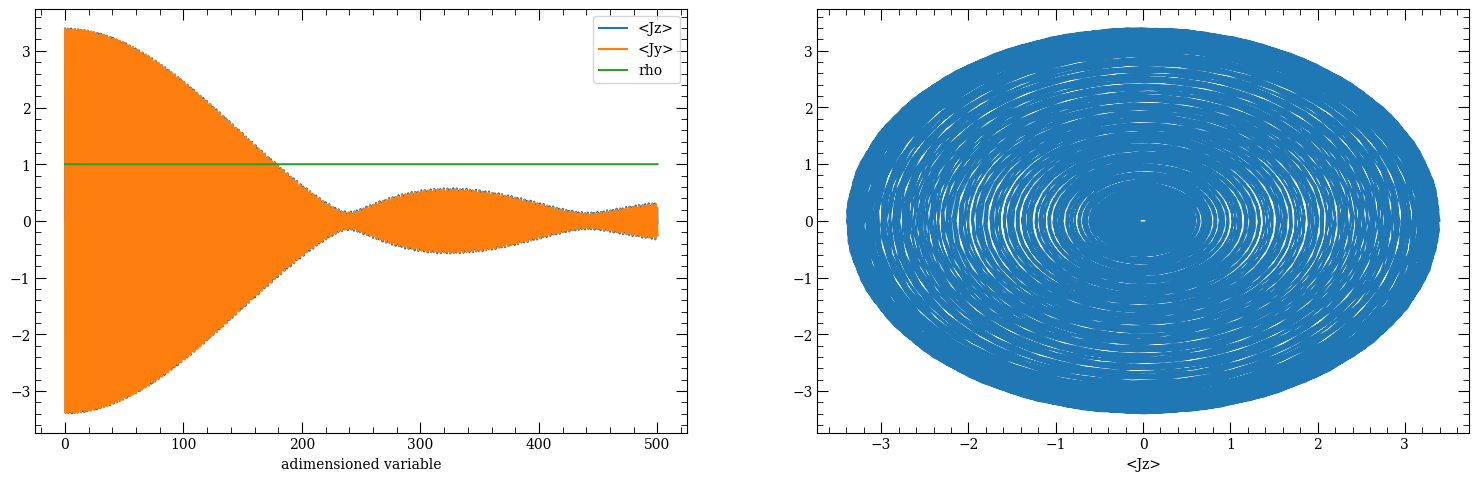

In [268]:
# print(monitor)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18.5, 5.5)
ax[0].plot(output.times, meanJz,label='<Jz>') 
ax[0].plot(output.times, meanJy,label='<Jy>') 
ax[0].plot(output.times, meanRho,label='rho') 
# ax[0].plot(output.times, monitor)
ax[0].set_xlabel('Time (T)') 
ax[0].set_xlabel('adimensioned variable') 
ax[0].legend()
# ax[0].set_xlim(0,3)

ax[1].plot(meanJy, meanJz) 
ax[1].set_xlabel('<Jy>') 
ax[1].set_xlabel('<Jz>') 

# Larmor frequency (kHz) of current simulation
print(1e-3*(1/T))




Text(0, 0.5, 'Power Spectral Density / dB/Hz')

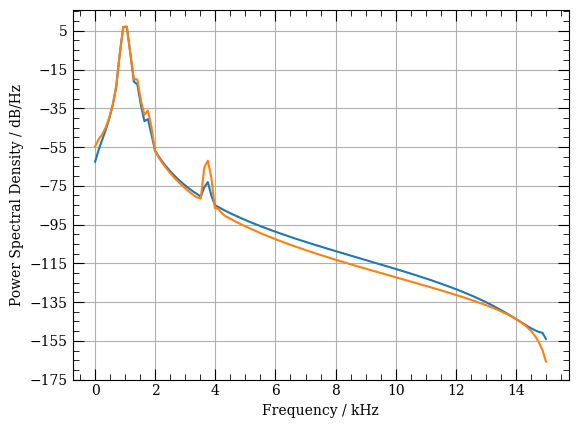

In [269]:
# plot Fourier transform of the result
Freqs = 1/(output.times[1] - output.times[0])
FFT_meanJy = plt.psd(meanJy,Fs=Freqs)
FFT_meanJz = plt.psd(meanJz,Fs=Freqs)
plt.xlabel('Frequency / kHz')
plt.ylabel('Power Spectral Density / dB/Hz')
# plt.xlim(0,10000)
# print(type(FFT_meanJx[0]))
# fig
# plt.plot(FFT_meanJy[1],FFT_meanJy[0])